In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
import tarfile
import os
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
testset[0][0][2]

tensor([[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
        [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
        [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.1294],
        ...,
        [0.6941, 0.5804, 0.5373,  ..., 0.5725, 0.4235, 0.4980],
        [0.6588, 0.5804, 0.5176,  ..., 0.5098, 0.4941, 0.4196],
        [0.6275, 0.5843, 0.5176,  ..., 0.4863, 0.5059, 0.4314]])

(6, torch.Size([3, 32, 32]))

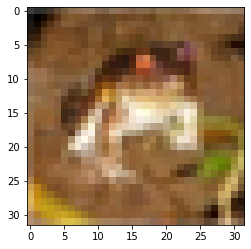

In [ ]:
img, label = trainset[0]
plt.imshow(img.permute(1, 2, 0))
label, img.shape

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        print(labels)
        break

In [ ]:
# show_batch(train_dl)

In [ ]:
l=[img.numpy() for img, _ in trainset]
imgs = np.array(l)
r, g, b = imgs[:, 0, :, :], imgs[:, 1, :, :], imgs[:, 2, :, :]
means = np.mean(r), np.mean(g), np.mean(b)
stds = np.std(r), np.std(g), np.std(b)
stats = means, stds

In [ ]:
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats, inplace=True)])
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=train_tfms)

In [ ]:
train_ds, val_ds = random_split(trainset, [45000, 5000])

batch = 100
img, _ = train_ds[0]
input_size = img.shape[0]*img.shape[1]*img.shape[2]

train_dl = DataLoader(trainset, batch, shuffle=True)
val_dl = DataLoader(val_ds, batch)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

tensor([8, 6, 9, 8, 4, 5, 6, 9, 1, 2, 5, 7, 5, 4, 6, 9, 4, 3, 5, 7, 2, 8, 2, 6,
        9, 0, 9, 8, 7, 4, 3, 3, 2, 7, 6, 4, 3, 0, 0, 0, 8, 6, 6, 4, 6, 1, 8, 4,
        6, 1, 9, 1, 0, 7, 0, 0, 3, 1, 2, 3, 8, 2, 8, 9, 8, 0, 4, 6, 9, 5, 1, 6,
        6, 3, 3, 4, 2, 9, 8, 3, 1, 8, 3, 5, 4, 0, 0, 5, 0, 3, 8, 0, 3, 6, 1, 2,
        8, 8, 6, 8])


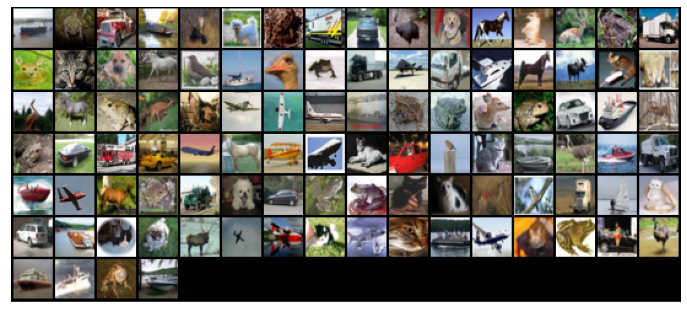

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
img = torch.zeros((3, 57, 57))
model=nn.Conv2d(3, 65, 3, 1, 1)
model(img.unsqueeze(0)).shape

torch.Size([1, 65, 57, 57])

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class Training_Modules(nn.Module):
  def cost(self, batch):
    imgs, labels = batch
    preds = self(imgs)
    loss = F.cross_entropy(preds, labels)
    return loss

  def val_step(self, batch):
    imgs, labels = batch
    preds = self(imgs)
    loss = F.cross_entropy(preds, labels)
    acc = accuracy(preds, labels)    
    return {'val_loss': loss, 'val_acc': acc}

  def validation_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]   
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def print_result(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def convolution_block(in_channels, out_channels, pooling = False, add_relu = True):
  layer_components = [
                      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(out_channels)
                      ]
  if add_relu:
    layer_components.append(nn.ReLU(inplace=True))
  if pooling:
    layer_components.append(nn.MaxPool2d(2))
  
  return nn.Sequential(*layer_components)

In [ ]:
class ResNet9(Training_Modules):
  def __init__(self, input_channels, num_classes):
    super().__init__()

    self.conv1 = convolution_block(input_channels, 16)


    self.res_block_1 = nn.Sequential(convolution_block(16, 16), convolution_block(16, 16, add_relu=False))
    self.res_block_2 = nn.Sequential(convolution_block(16, 16), convolution_block(16, 16, add_relu=False))
    self.res_block_3 = nn.Sequential(convolution_block(16, 32, pooling=True), convolution_block(32, 32, add_relu=False))

    self.projection_1 = nn.Conv2d(16, 32, (1, 1), 2)

    self.res_block_4 = nn.Sequential(convolution_block(32, 32), convolution_block(32, 32, add_relu=False))
    self.res_block_5 = nn.Sequential(convolution_block(32, 64, pooling=True), convolution_block(64, 64, add_relu=False))

    self.projection_2 = nn.Conv2d(32, 64, (1, 1), 2)

    self.res_block_6 = nn.Sequential(convolution_block(64, 64), convolution_block(64, 64, add_relu=False))
    self.res_block_7 = nn.Sequential(convolution_block(64, 128, pooling=True), convolution_block(128, 128, add_relu=False))

    self.projection_3 = nn.Conv2d(64, 128, (1, 1), 2)

    self.res_block_8 = nn.Sequential(convolution_block(128, 128), convolution_block(128, 128, add_relu=False))


    self.avg_pool = nn.AvgPool2d(4)
    self.flat = nn.Flatten()

    self.feed_forward_network = nn.Sequential(
        nn.Linear(128, 1000),
        nn.ReLU(),
        nn.Linear(1000, num_classes)
    )

  def forward(self, x):
    a_1 = self.conv1(x)
    F_x = self.res_block_1(a_1) 
    y = F_x + a_1
    # print(y.shape)
    a_2 = F.relu(y)
    F_x = self.res_block_2(a_2)
    y = F_x + a_2
    # print(y.shape)
    a_3 = F.relu(y)
    F_x = self.res_block_3(a_3)
    y = F_x + self.projection_1(a_3)
    # print(y.shape)
    a_4 = F.relu(y)
    F_x = self.res_block_4(a_4)
    y = F_x + a_4
    # print(y.shape)
    a_5 = F.relu(y)
    F_x = self.res_block_5(a_5)
    y = F_x + self.projection_2(a_5)
    # print(y.shape)
    a_6 = F.relu(y)
    F_x = self.res_block_6(a_6)
    y = F_x + a_6
    # print(y.shape)
    a_7 = F.relu(y)
    F_x = self.res_block_7(a_7)
    y = F_x + self.projection_3(a_7)
    # print(y.shape)
    a_8 = F.relu(y)
    F_x = self.res_block_8(a_8)
    y = F_x + a_8
    # print(y.shape)
    a_9 = F.relu(y)
    down_sample_y = self.avg_pool(y)
    flatted_y = self.flat(down_sample_y)
    # print(flatted_y.shape)
    a_10 = self.feed_forward_network(flatted_y)
    # print(a_10.shape)
    return a_10
  

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
  outputs = [model.val_step(batch) for batch in val_dl]
  
  return model.validation_end(outputs)

def train(epochs, lr, model, tain_dl, val_dl, opt_fn = torch.optim.Adam):
  history = []
  optimizer = opt_fn(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_dl:
      loss = model.cost(batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    result = evaluate(model, val_dl)
    model.print_result(epoch, result)
    history.append(result)

  return history

In [ ]:
model = to_device(ResNet9(3, 10), device)
model_data_augment = to_device(ResNet9(3, 10), device)

In [ ]:
history = train(8, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.0480, val_acc: 0.6292
Epoch [1], val_loss: 0.8955, val_acc: 0.6764
Epoch [2], val_loss: 0.7393, val_acc: 0.7398
Epoch [3], val_loss: 0.6569, val_acc: 0.7686
Epoch [4], val_loss: 0.5991, val_acc: 0.7882
Epoch [5], val_loss: 0.5596, val_acc: 0.8016
Epoch [6], val_loss: 0.5060, val_acc: 0.8210
Epoch [7], val_loss: 0.4951, val_acc: 0.8292


In [ ]:
model.res_block_1[0][0].weight.grad

In [ ]:
history_2 = train(25, 0.001, model_data_augment, train_dl, val_dl)

Epoch [0], val_loss: 0.9575, val_acc: 0.6550
Epoch [1], val_loss: 0.7143, val_acc: 0.7532
Epoch [2], val_loss: 0.5718, val_acc: 0.8020
Epoch [3], val_loss: 0.4491, val_acc: 0.8452
Epoch [4], val_loss: 0.3899, val_acc: 0.8694
Epoch [5], val_loss: 0.3039, val_acc: 0.8948
Epoch [6], val_loss: 0.2530, val_acc: 0.9112
Epoch [7], val_loss: 0.2102, val_acc: 0.9274
Epoch [8], val_loss: 0.1671, val_acc: 0.9446
Epoch [9], val_loss: 0.1477, val_acc: 0.9492
Epoch [10], val_loss: 0.1054, val_acc: 0.9648
Epoch [11], val_loss: 0.1150, val_acc: 0.9596
Epoch [12], val_loss: 0.1156, val_acc: 0.9604
Epoch [13], val_loss: 0.0803, val_acc: 0.9722
Epoch [14], val_loss: 0.0689, val_acc: 0.9754
Epoch [15], val_loss: 0.0586, val_acc: 0.9792
Epoch [16], val_loss: 0.0608, val_acc: 0.9812
Epoch [17], val_loss: 0.0759, val_acc: 0.9734
Epoch [18], val_loss: 0.0624, val_acc: 0.9754
Epoch [19], val_loss: 0.0415, val_acc: 0.9866
Epoch [20], val_loss: 0.0431, val_acc: 0.9862
Epoch [21], val_loss: 0.0524, val_acc: 0.983

In [ ]:
history_2 += train(25, 0.001, model_data_augment, train_dl, val_dl)

Epoch [0], val_loss: 0.0293, val_acc: 0.9920
Epoch [1], val_loss: 0.0381, val_acc: 0.9878
Epoch [2], val_loss: 0.0459, val_acc: 0.9850
Epoch [3], val_loss: 0.0260, val_acc: 0.9908
Epoch [4], val_loss: 0.0363, val_acc: 0.9876
Epoch [5], val_loss: 0.0412, val_acc: 0.9858
Epoch [6], val_loss: 0.0443, val_acc: 0.9848
Epoch [7], val_loss: 0.0315, val_acc: 0.9884
Epoch [8], val_loss: 0.0444, val_acc: 0.9858
Epoch [9], val_loss: 0.0232, val_acc: 0.9920
Epoch [10], val_loss: 0.0255, val_acc: 0.9902
Epoch [11], val_loss: 0.0258, val_acc: 0.9918
Epoch [12], val_loss: 0.0277, val_acc: 0.9900
Epoch [13], val_loss: 0.0373, val_acc: 0.9860
Epoch [14], val_loss: 0.0219, val_acc: 0.9924
Epoch [15], val_loss: 0.0205, val_acc: 0.9942
Epoch [16], val_loss: 0.0155, val_acc: 0.9954
Epoch [17], val_loss: 0.0366, val_acc: 0.9878
Epoch [18], val_loss: 0.0275, val_acc: 0.9904
Epoch [19], val_loss: 0.0229, val_acc: 0.9928
Epoch [20], val_loss: 0.0276, val_acc: 0.9908
Epoch [21], val_loss: 0.0208, val_acc: 0.992

In [ ]:
model_data_augment.res_block_1[0][0].weight.grad

tensor([[[[ 2.3353e-03, -2.5485e-03,  3.4934e-03],
          [ 9.3596e-04, -1.9668e-04,  1.7713e-04],
          [ 2.3631e-03,  1.8037e-03, -3.3249e-03]],

         [[ 4.0406e-03, -7.7816e-03,  3.1157e-03],
          [ 3.6020e-03, -1.3919e-03, -3.3963e-05],
          [ 1.0494e-03,  4.5145e-03, -1.3643e-03]],

         [[-3.8023e-03, -5.8458e-03, -4.4357e-03],
          [-6.5309e-03, -3.2745e-03, -1.4305e-02],
          [-1.2103e-02,  2.5685e-04, -9.9819e-03]],

         ...,

         [[ 2.1117e-03,  4.7823e-03,  4.9666e-03],
          [ 8.5982e-04,  5.8864e-03,  3.0947e-03],
          [ 2.3077e-03,  2.8334e-03,  4.6533e-03]],

         [[ 6.7112e-03, -2.7646e-03, -1.5458e-02],
          [-1.4203e-02, -4.5242e-03, -1.8719e-02],
          [-1.5083e-02,  1.5060e-03, -1.9823e-03]],

         [[ 3.8424e-03, -2.6619e-03,  4.6250e-03],
          [-2.1267e-02, -1.1866e-02, -3.4157e-03],
          [-1.9091e-02, -2.9374e-03,  1.4427e-02]]],


        [[[-3.9794e-03, -5.3824e-03, -8.7171e-03],
  

In [ ]:
model_BN = to_device(ResNet9(3, 10), device)
model_BN

In [ ]:
history_3 = train(50, 0.001, model_BN, train_dl, val_dl)

Epoch [0], val_loss: 1.5838, val_acc: 0.4178
Epoch [1], val_loss: 1.3086, val_acc: 0.5208
Epoch [2], val_loss: 1.0720, val_acc: 0.6108
Epoch [3], val_loss: 0.9727, val_acc: 0.6570
Epoch [4], val_loss: 0.7683, val_acc: 0.7260
Epoch [5], val_loss: 0.6976, val_acc: 0.7626
Epoch [6], val_loss: 0.5755, val_acc: 0.7980
Epoch [7], val_loss: 0.5105, val_acc: 0.8280
Epoch [8], val_loss: 0.4490, val_acc: 0.8444
Epoch [9], val_loss: 0.3794, val_acc: 0.8686
Epoch [10], val_loss: 0.3352, val_acc: 0.8828
Epoch [11], val_loss: 0.2890, val_acc: 0.8962
Epoch [12], val_loss: 0.2815, val_acc: 0.9002
Epoch [13], val_loss: 0.2768, val_acc: 0.9046
Epoch [14], val_loss: 0.2475, val_acc: 0.9134
Epoch [15], val_loss: 0.2210, val_acc: 0.9230
Epoch [16], val_loss: 0.2131, val_acc: 0.9266
Epoch [17], val_loss: 0.1673, val_acc: 0.9438
Epoch [18], val_loss: 0.1313, val_acc: 0.9552
Epoch [19], val_loss: 0.1455, val_acc: 0.9500
Epoch [20], val_loss: 0.1484, val_acc: 0.9472
Epoch [21], val_loss: 0.1342, val_acc: 0.954

In [ ]:
history_3 += train(12, 0.001, model_BN, train_dl, val_dl)

In [ ]:
model_BN.res_block_1[0][0].weight.grad

tensor([[[[ 2.2905e-03,  3.1275e-03,  3.9198e-03],
          [ 2.7384e-03,  2.6577e-03,  2.7113e-03],
          [ 8.9326e-04,  1.6730e-03,  2.6170e-03]],

         [[-1.3626e-03,  6.5259e-04,  2.8249e-03],
          [-3.4363e-03, -1.1102e-03, -5.1494e-04],
          [-4.7318e-03, -1.6803e-03, -1.1680e-03]],

         [[-1.7165e-04, -1.3510e-03, -3.5231e-03],
          [-4.5201e-03, -3.2481e-03, -4.4626e-03],
          [-3.3215e-03, -1.5843e-03, -3.2887e-03]],

         ...,

         [[ 8.3810e-04,  9.5525e-04,  1.3676e-03],
          [ 1.3430e-03,  5.1430e-04,  1.5886e-03],
          [ 4.4836e-04,  1.2167e-03,  1.7322e-05]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[-5.3031e-04,  3.5858e-04, -3.7966e-04],
          [-7.8865e-04, -9.2312e-04, -2.0981e-03],
          [ 6.4424e-04, -5.7975e-04, -1.5532e-03]]],


        [[[-2.2686e-04, -9.2156e-04, -5.9328e-04],
  

In [ ]:
def countZeroWeights(model):
    zeros = 0
    for param in model.parameters():
        if param.grad is not None:
          zeros += param.grad.numel() - param.grad.count_nonzero()
    return zeros
    
countZeroWeights(model_BN), countZeroWeights(model_data_augment)

(tensor(327898, device='cuda:0'), tensor(61947, device='cuda:0'))

In [ ]:
from torchsummary import summary
summary(model_BN, (3, 32, 32)), summary(model_data_augment, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           2,320
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
            Conv2d-6           [-1, 16, 32, 32]           2,320
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,320
            Conv2d-9           [-1, 32, 32, 32]           4,640
             ReLU-10           [-1, 32, 32, 32]               0
        MaxPool2d-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]           9,248
           Conv2d-13           [-1, 32, 16, 16]             544
           Conv2d-14           [-1, 32,

(None, None)

Text(0, 0.5, 'loss')

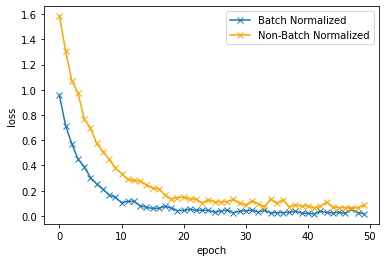

In [ ]:
losses_1 = [result['val_loss'] for result in history_2]
losses_2 = [result['val_loss'] for result in history_3]
plt.plot(losses_1, '-x')
plt.plot(losses_2, '-x', color="orange")
plt.legend(["Batch Normalized", "Non-Batch Normalized"])
plt.xlabel('epoch')
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

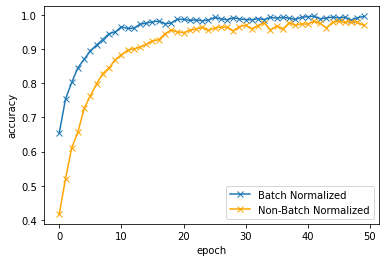

In [ ]:
accuracies_1 = [result['val_acc'] for result in history_2]
accuracies_2 = [result['val_acc'] for result in history_3]
plt.plot(accuracies_1, '-x')
plt.plot(accuracies_2, '-x', color="orange")
plt.legend(["Batch Normalized", "Non-Batch Normalized"])
plt.xlabel('epoch')
plt.ylabel("accuracy")